# 学習と評価
 - FaceNetの利用

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
from pathlib import Path

In [6]:
import tensorflow as tf

In [7]:
tf.__version__

'2.8.0'

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
from sklearn.model_selection import KFold

## データのロード

- 画像サイズは224×224

In [10]:
df = pd.read_csv("data1_union.csv")

In [11]:
df

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,6269,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,272998,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,274783,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,430823,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,208848,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
80,185955,0.0,1.0,1.0,1.0,1.0,0.0,0.0
81,313100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
82,369866,1.0,1.0,0.0,1.0,1.0,0.0,0.0
83,124821,0.0,1.0,1.0,1.0,0.0,0.0,1.0


## FaceNetで埋め込み

メモ：```\Lib\site-packages\facenet\src\facenet.py```の408行目をtensorflow v2仕様に書き換える必要がある

In [12]:
from face_embedding import FaceEmbedding

In [13]:
FACE_MEDEL_PATH = '../facenet//20180402-114759/20180402-114759.pb'
face_embedding = FaceEmbedding(FACE_MEDEL_PATH)

Model filename: ../facenet//20180402-114759/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.


In [14]:
X = []
for img_id in df["Id"]:
    path = f"images/cleaned_20220519/{img_id}.jpg"
    face_vec = face_embedding.face_embeddings(path)[0]
    X.append(face_vec)

In [15]:
X = np.array(X)

In [16]:
X.shape

(85, 512)

# 二値分類モデル

## モデル構築

In [17]:
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Lambda, Conv2D, Reshape, Input, RandomFlip, RandomRotation

In [18]:
def get_binary_model(fine=False):
    input_ts = Input(shape=(512,))
    dense1 = Dense(512, activation="relu")(input_ts)
    dense2 = Dense(1024, activation="relu")(dense1)
    drop1 = Dropout(0.4)(dense2)
    dense3 = Dense(1024, activation="relu")(drop1)
    drop2 = Dropout(0.4)(dense3)
    dense4 = Dense(512, activation="relu")(drop2)
    dense5 = Dense(256, activation="relu")(dense4)
    dense6 = Dense(128, activation="relu")(dense5)
    drop3 = Dropout(0.2)(dense6)
    final = Dense(2, activation="softmax")(drop3)
    
    model = Model(
        inputs=[input_ts],
        outputs=[final]
    )
    return model

In [24]:
model = get_binary_model()

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               5248

In [26]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [27]:
del model

In [28]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [29]:
from sklearn.metrics import f1_score

cf. https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric/notebook

In [40]:
from tensorflow.keras import backend as K

In [45]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

## すべてのラベルでやってみる

In [46]:
labels = ["Caring","Confident","Emotionally stable","Intelligent","Responsible","Sociable","Trustworthy"]

In [47]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [55]:
f1_dict = dict()

for label in labels:
    y_raw = df[label]
    y = tf.keras.utils.to_categorical(y_raw)
    
    f1_dict[label] = []
    print(label)
    
    for train_index, test_index in kf.split(X):     
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        neg = y_train.sum(axis=0)[0]
        pos = y_train.sum(axis=0)[1]
        total = pos + neg
        print(f"origin pos:{pos} neg:{neg}")

        # クラスの重み
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        model = get_binary_model()
        
        # 初期重みの最適化
        initial_bias = np.log([neg/pos])
        model.layers[-1].bias_initializer=initial_bias
        
        model.compile(loss=f1_loss, optimizer="adam", metrics=METRICS)
        model.fit(X_train, y_train, batch_size=8, epochs=6, class_weight=class_weight)
        y_pred_tf = model.predict(X_test, batch_size=1)
        y_pred = np.argmax(y_pred_tf, axis=1)
        y_test_sk = np.argmax(y_test, axis=1)
        print("Predict:", y_pred)
        print("True:", y_test_sk)
        f1 = f1_score(y_test_sk, y_pred, average="binary")
        print("F1 score:", f1)
        f1_dict[label].append(f1)
    

Caring
origin pos:21.0 neg:35.0
Epoch 1/6
7/7 [==============================] - 1s 22ms/step - loss: 0.5213 - tp: 95.0000 - fp: 18.0000 - tn: 95.0000 - fn: 18.0000 - accuracy: 0.8407 - precision: 0.8407 - recall: 0.8407 - auc: 0.8855
Epoch 2/6
7/7 [==============================] - 0s 21ms/step - loss: 0.4871 - tp: 35.0000 - fp: 21.0000 - tn: 35.0000 - fn: 21.0000 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.7305
Epoch 3/6
7/7 [==============================] - 0s 7ms/step - loss: 0.4449 - tp: 33.0000 - fp: 23.0000 - tn: 33.0000 - fn: 23.0000 - accuracy: 0.5893 - precision: 0.5893 - recall: 0.5893 - auc: 0.7714
Epoch 4/6
7/7 [==============================] - 0s 7ms/step - loss: 0.3980 - tp: 45.0000 - fp: 11.0000 - tn: 45.0000 - fn: 11.0000 - accuracy: 0.8036 - precision: 0.8036 - recall: 0.8036 - auc: 0.8253
Epoch 5/6
7/7 [==============================] - 0s 7ms/step - loss: 0.2701 - tp: 45.0000 - fp: 11.0000 - tn: 45.0000 - fn: 11.0000 - accuracy: 0.8036 - preci

8/8 [==============================] - 0s 12ms/step - loss: 0.1002 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9929
Predict: [1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1]
True: [1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1]
F1 score: 0.7441860465116279
Emotionally stable
origin pos:16.0 neg:40.0
Epoch 1/6
7/7 [==============================] - 1s 11ms/step - loss: 0.5169 - tp: 96.0000 - fp: 17.0000 - tn: 96.0000 - fn: 17.0000 - accuracy: 0.8496 - precision: 0.8496 - recall: 0.8496 - auc: 0.9307
Epoch 2/6
7/7 [==============================] - 0s 11ms/step - loss: 0.4853 - tp: 40.0000 - fp: 16.0000 - tn: 40.0000 - fn: 16.0000 - accuracy: 0.7143 - precision: 0.7143 - recall: 0.7143 - auc: 0.8208
Epoch 3/6
7/7 [==============================] - 0s 11ms/step - loss: 0.4091 - tp: 40.0000 - fp: 16.0000 - tn: 40.0000 - fn: 16.0000 - accuracy: 0.7143 - precision: 0.7143 - recall: 0.7143 - auc: 0.8

Epoch 5/6
8/8 [==============================] - 0s 12ms/step - loss: 0.1780 - tp: 50.0000 - fp: 7.0000 - tn: 50.0000 - fn: 7.0000 - accuracy: 0.8772 - precision: 0.8772 - recall: 0.8772 - auc: 0.9594
Epoch 6/6
8/8 [==============================] - 0s 12ms/step - loss: 0.2859 - tp: 42.0000 - fp: 15.0000 - tn: 42.0000 - fn: 15.0000 - accuracy: 0.7368 - precision: 0.7368 - recall: 0.7368 - auc: 0.8104
Predict: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
True: [0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1]
F1 score: 0.7555555555555556
Responsible
origin pos:25.0 neg:31.0
Epoch 1/6
7/7 [==============================] - 1s 10ms/step - loss: 0.5086 - tp: 68.0000 - fp: 45.0000 - tn: 68.0000 - fn: 45.0000 - accuracy: 0.6018 - precision: 0.6018 - recall: 0.6018 - auc: 0.6960
Epoch 2/6
7/7 [==============================] - 0s 11ms/step - loss: 0.4925 - tp: 38.0000 - fp: 18.0000 - tn: 38.0000 - fn: 18.0000 - accuracy: 0.6786 - precision: 0.6786 - recall: 0.6786 - auc: 

8/8 [==============================] - 0s 11ms/step - loss: 0.4062 - tp: 41.0000 - fp: 16.0000 - tn: 41.0000 - fn: 16.0000 - accuracy: 0.7193 - precision: 0.7193 - recall: 0.7193 - auc: 0.8447
Epoch 5/6
8/8 [==============================] - 0s 11ms/step - loss: 0.1738 - tp: 55.0000 - fp: 2.0000 - tn: 55.0000 - fn: 2.0000 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9609
Epoch 6/6
8/8 [==============================] - 0s 9ms/step - loss: 0.1059 - tp: 52.0000 - fp: 5.0000 - tn: 52.0000 - fn: 5.0000 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9701
Predict: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
True: [0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0]
F1 score: 0.30769230769230765
Trustworthy
origin pos:10.0 neg:46.0
Epoch 1/6
7/7 [==============================] - 1s 7ms/step - loss: 0.5240 - tp: 98.0000 - fp: 15.0000 - tn: 98.0000 - fn: 15.0000 - accuracy: 0.8673 - precision: 0.8673 - recall: 0.8673 - auc: 0.9256
Epoch 

In [56]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))
macro_f1_val = np.mean(f1_list) 

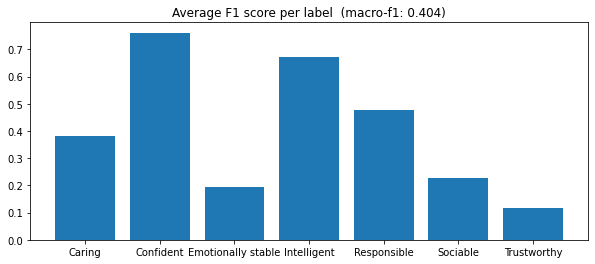

In [61]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title(f"Average F1 score per label  (macro-f1: {macro_f1_val:.3f})")
plt.show() ;

### いろいろやってみてわかること
 - Predictを見るとわかるが，まったく学習できていない
 - 役に立たない　やはりデータが少なすぎるか
 - f1をlossに用いるほうが全然良い
 - macro-f1はf1の平均

# マルチラベル問題

cf．https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72

In [51]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1